In [1]:
# make sure the PWD is set to the main `toto` directory
%cd ..

import os

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

from data.util.dataset import MaskedTimeseries
from inference.forecaster import TotoForecaster
from model.toto import Toto

# These lines make gpu execution in CUDA deterministic
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True)

/home/annamalai/Desktop/Salesforce/toto/toto/toto


/home/annamalai/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Time series forecasting with Toto

In this notebook, you'll learn how to perform inference with Toto for multivariate time series forecasting on the classic ETT dataset. Toto is a foundation model used for *zero-shot* forecasting,
meaning no training is required. We simply provide the historical context of a time series to Toto as input, and Toto produces forecasts of the desired length.

## Prerequisites

You'll need to run this with a CUDA-capable device. In order to get the fastest inference performance, please use an Ampere or newer architecture, as these support the xFormers fused kernel implementations for SwiGLU and Memory-Efficient Attention.

Make sure you've cloned the repo and installed dependencies with `pip install -r requirements.txt`. When running this notebook, make sure the working directory is set to `<repository_root>/toto`.

This notebook also assumes that you've downloaded the `ETT-small` dataset locally. It can be obtained from the [official repo](https://github.com/zhouhaoyi/ETDataset).


## Load data
As an example, we'll look at the ETTm1 sub-dataset:

In [4]:
ETT_LOCAL_PATH = "."  # UPDATE WITH YOUR LOCAL PATH

df = (
    pd.read_csv("./../../../hourly_dataset/1.csv")
    .assign(date=lambda df: pd.to_datetime(df["time"]))
    .assign(timestamp_seconds=lambda df: (df.date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
)

df

,time,value,date,timestamp_seconds
0,2024-06-10 00:00:00,13.512998,2024-06-10 00:00:00,1717977600
1,2024-06-10 01:00:00,13.761486,2024-06-10 01:00:00,1717981200
2,2024-06-10 02:00:00,13.583373,2024-06-10 02:00:00,1717984800
3,2024-06-10 03:00:00,13.276434,2024-06-10 03:00:00,1717988400
4,2024-06-10 04:00:00,13.985233,2024-06-10 04:00:00,1717992000
...,...,...,...,...
1819,2024-08-24 19:00:00,14.629404,2024-08-24 19:00:00,1724526000
1820,2024-08-24 20:00:00,14.620975,2024-08-24 20:00:00,1724529600
1821,2024-08-24 21:00:00,16.041689,2024-08-24 21:00:00,1724533200
1822,2024-08-24 22:00:00,15.457575,2024-08-24 22:00:00,1724536800


## Preprocess data

In the following section, we prepare the data in the expected input format of Toto.

Toto expects inputs to be multivariate time series data in the shape

$\text{Variate} \times \text{Time Steps}$

or, with optional batch dimension:

$\text{Batch} \times \text{Variate} \times \text{Time Steps}$

For illustration, we'll try to predict the last 96 steps of the ETTm1 time series across its 7 covariates. We'll do this using the preceding 1024 steps as context. 2048 gives a good balance of speed vs. performance; you may want to experiment with different context lengths depending on your dataset. Toto was trained with a max context length of 4096, but can extrapolate to even longer contexts. 


In [14]:
context_length = 69*24
prediction_length = 24*7

Slice the ETTm1 data accordingly

In [15]:
feature_columns = ["value"]
n_variates = len(feature_columns)
interval = 60 * 60  # 15-min intervals
input_df = df.iloc[-(context_length+prediction_length):-prediction_length]
target_df = df.iloc[-prediction_length:]
DEVICE = "cuda"

input_series = torch.from_numpy(input_df[feature_columns].values.T).to(torch.float).to(DEVICE)
input_series.shape


torch.Size([1, 1656])

Add timestamp features to the data. Note: the current version of Toto does not use these features; it handles series of different time resolutions implicitly. However, future versions may take this into account, so the API expects timestamps to be passed in.

In [16]:
timestamp_seconds = torch.from_numpy(input_df.timestamp_seconds.values.T).expand((n_variates, context_length)).to(input_series.device)
time_interval_seconds=torch.full((n_variates,), interval).to(input_series.device)
start_timestamp_seconds = timestamp_seconds[:, 0]

Toto expects its inputs in the form of a `MaskedTimeseries` dataclass.

In [17]:
inputs = MaskedTimeseries(
    series=input_series,
    # The padding mask should be the same shape as the input series.
    # It should be 0 to indicate padding and 1 to indicate valid values.
    padding_mask=torch.full_like(input_series, True, dtype=torch.bool),
    # The ID mask is used for packing unrelated time series along the Variate dimension.
    # This is used in training, and can also be useful for large-scale batch inference in order to
    # process time series of different numbers of variates using batches of a fixed shape.
    # The ID mask controls the channel-wise attention; variates with different IDs cannot attend to each other.
    # If you're not using packing, just set this to zeros.
    id_mask=torch.zeros_like(input_series),
    # As mentioned above, these timestamp features are not currently used by the model;
    # however, they are reserved for future releases.
    timestamp_seconds=timestamp_seconds,
    time_interval_seconds=time_interval_seconds,
)

Now our data is ready!

## Load Toto checkpoint

Download a Toto checkpoint from Hugging Face (TBD) to a local directory

In [9]:
toto = Toto.from_pretrained('Datadog/Toto-Open-Base-1.0')
toto.to(DEVICE)

# Optionally enable Torch's JIT compilation to speed up inference. This is mainly
# helpful if you want to perform repeated inference, as the JIT compilation can
# take time to wrm up.
toto.compile()

config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

We generate multistep, autoregressive forecasts using the `TotoForecaster` class. 

In [18]:
forecaster = TotoForecaster(toto.model)
forecast = forecaster.forecast(
    inputs,
    # We can set any number of timesteps into the future that we'd like to forecast. Because Toto is an autoregressive model,
    # the inference time will be longer for longer forecasts. 
    prediction_length=prediction_length,
    # TOTOForecaster draws samples from a predicted parametric distribution. The more samples, the more stable and accurate the prediction.
    # This is especially important if you care about accurate prediction intervals in the tails.
    # Toto's evaluations were performed using 256 samples. Set this according to your compute budget.
    num_samples=256,
    # TOTOForecaster also handles batching the samples in order to control memory usage.
    # Set samples_per_batch as high as you can without getting OOMs for maximum performance.
    # If you're doing batch inference, the effective batch size sent to the model is (batch_size x samples_per_batch).
    # In this notebook, we're doing unbatched inference, so the effective batch size is samples_per_batch.
    samples_per_batch=256,
    # KV cache should significantly speed up inference, and in most cases should reduce memory usage too.
    use_kv_cache=True,
)

## Visualize the forecasts

We can plot our forecasts and confidence intervals against the ground truth:

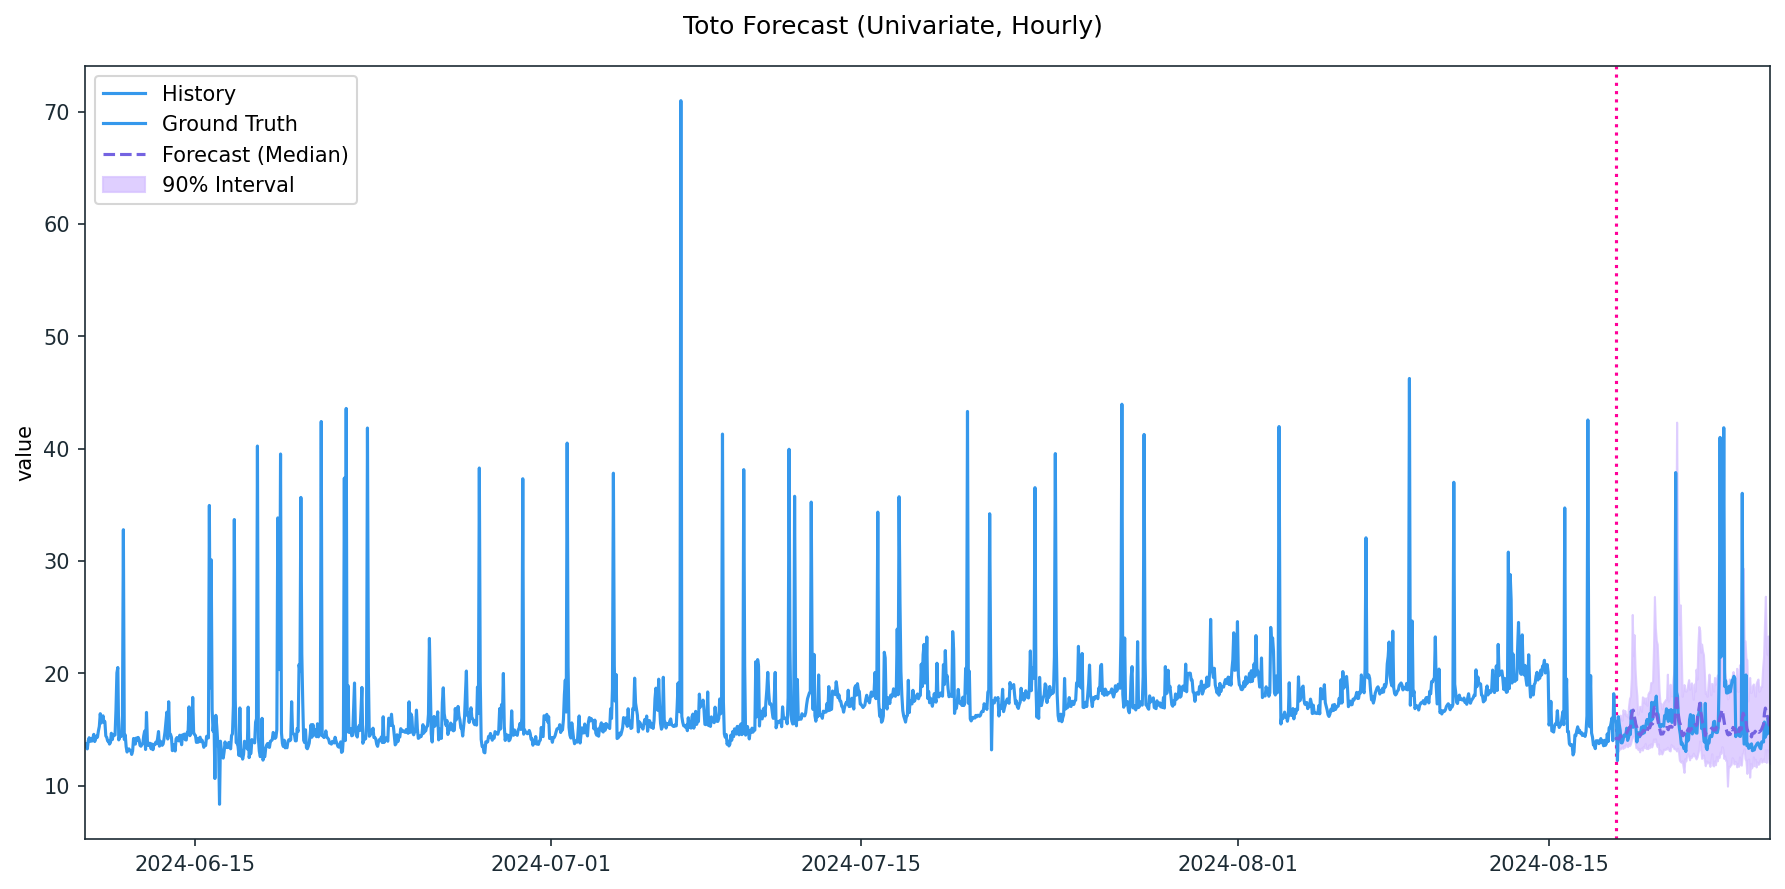

In [19]:
DARK_GREY = "#1c2b34"
BLUE = "#3598ec"
PURPLE = "#7463e1"
LIGHT_PURPLE = "#d7c3ff"
PINK = "#ff0099"

matplotlib.rc("axes", edgecolor=DARK_GREY)
fig = plt.figure(figsize=(12, 6), layout="tight", dpi=150)
plt.suptitle("Toto Forecast (Univariate, Hourly)")

feature = feature_columns[0]  # e.g., "value"

plt.subplot(1, 1, 1)
plt.tick_params(axis="x", color=DARK_GREY, labelcolor=DARK_GREY)
plt.tick_params(axis="y", color=DARK_GREY, labelcolor=DARK_GREY)
plt.ylabel(feature)
plt.xlim(input_df.date.iloc[0], target_df.date.iloc[-1])
plt.axvline(target_df.date.iloc[0], color=PINK, linestyle=":")

# Plot ground truth
plt.plot(input_df["date"], input_df[feature], color=BLUE, label="History")
plt.plot(target_df["date"], target_df[feature], color=BLUE, label="Ground Truth")

# Plot point forecasts
plt.plot(
    target_df["date"],
    np.median(forecast.samples.squeeze().cpu(), axis=-1),
    color=PURPLE,
    linestyle="--",
    label="Forecast (Median)"
)

# Plot quantiles
alpha = 0.05
qs = forecast.samples.quantile(q=torch.tensor([alpha, 1 - alpha], device=forecast.samples.device), dim=-1)
plt.fill_between(
    target_df["date"],
    qs[0].squeeze().cpu(),
    qs[1].squeeze().cpu(),
    color=LIGHT_PURPLE,
    alpha=0.8,
    label="90% Interval"
)

plt.legend()
plt.show()

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get ground truth and predictions as numpy arrays
y_true = target_df[feature].values
y_pred = np.median(forecast.samples.squeeze().cpu().numpy(), axis=-1)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# R-squared
r2 = r2_score(y_true, y_pred)

# SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
smape_val = smape(y_true, y_pred)

# MAPE
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8)))
mape_val = mape(y_true, y_pred)

# Mean Error
mean_error = np.mean(y_pred - y_true)

# Std Error
std_error = np.std(y_pred - y_true)

# Under/Over Predictions
under_predictions = np.sum(y_pred < y_true)
over_predictions = np.sum(y_pred > y_true)

# Print metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"SMAPE: {smape_val:.4f}")
print(f"MAPE: {mape_val:.4f}")
print(f"Mean Error: {mean_error:.4f}")
print(f"Std Error: {std_error:.4f}")
print(f"Under Predictions: {under_predictions}")
print(f"Over Predictions: {over_predictions}")

RMSE: 3.9644
MAE: 1.7166
R-squared: 0.0616
SMAPE: 9.3115
MAPE: 8.5208
Mean Error: -0.8170
Std Error: 3.8793
Under Predictions: 75
Over Predictions: 93
